In [ ]:
!python -m spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import re
import os
import io
import json

import pandas as pd
import numpy as np

#Datavisualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS

#Import Spacy and english initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

import string
from string import digits

#Import Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

#Split the dataset
from sklearn.model_selection import train_test_split
#For the metrics
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

#Stop warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv("/content/train_data.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## **1.-EXPLORATORY DATA ANALYSIS**

In [3]:
print(f" This dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")

 This dataset contains 7613 rows and 5 columns.


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# Now, it's time to check the missing values
missing_values = pd.DataFrame(train.isnull().sum()/len(train)*100, columns= ["Val_null"]).round()

In [6]:
missing_values

,Val_null
id,0.0
keyword,1.0
location,33.0
text,0.0
target,0.0


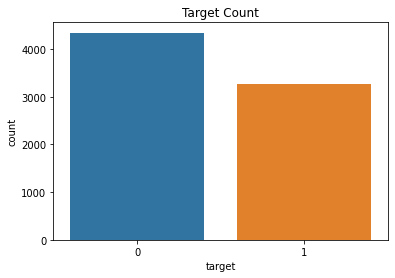

In [7]:
sns.countplot(data=train, x="target").set_title("Target Count");

In [8]:
train["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [9]:
# Remove %20 from the keyword
train["keyword_clean"] = train["keyword"].str.replace("%20"," ")

In [10]:
# Check keyword_clean
train["keyword_clean"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

In [11]:
train["keyword_clean"].value_counts()


fatalities             45
deluge                 42
armageddon             42
sinking                41
damage                 41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword_clean, Length: 221, dtype: int64

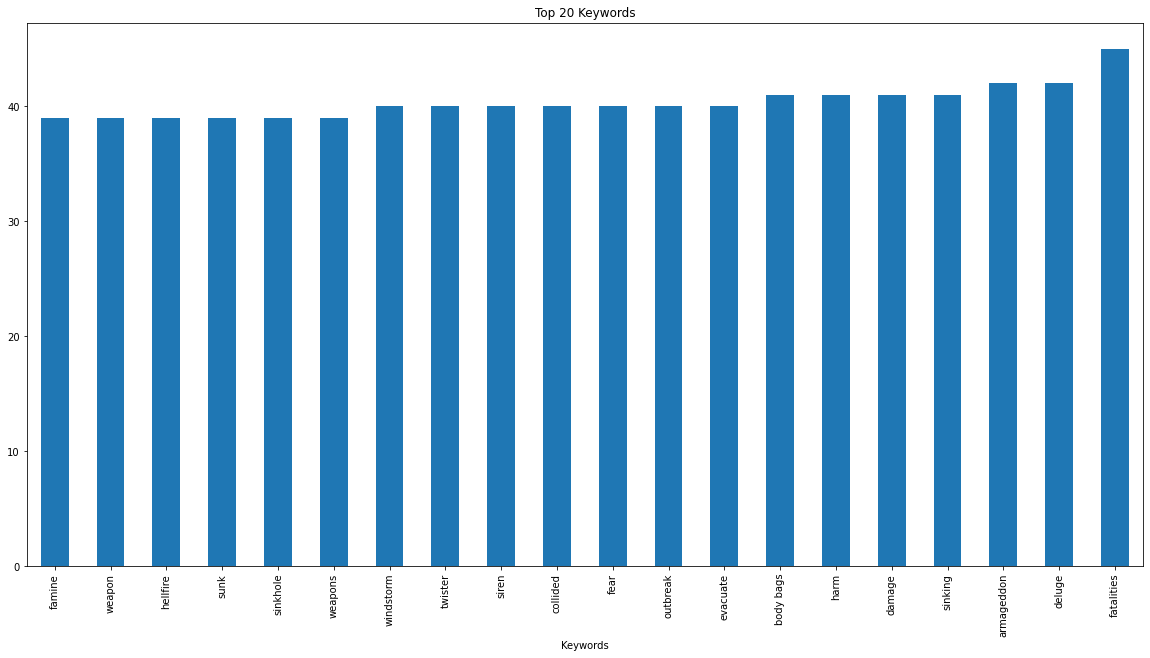

In [ ]:
ax = train["keyword_clean"].value_counts()[:20].sort_values().plot(kind="bar", title = "Top 20 Keywords",figsize =(20,10) )
ax.set_xlabel("Keywords")
plt.show()

In [12]:
disaster_keywords = train.loc[train["target"] == 1]["keyword_clean"].value_counts()
disaster_keywords

derailment     39
wreckage       39
outbreak       39
debris         37
oil spill      37
               ..
blazing         1
epicentre       1
body bag        1
electrocute     1
ruin            1
Name: keyword_clean, Length: 220, dtype: int64

In [13]:
nondisaster_keywords = train.loc[train["target"] == 0]["keyword_clean"].value_counts()
nondisaster_keywords

body bags          40
harm               37
armageddon         37
wrecked            36
ruin               36
                   ..
typhoon             1
suicide bombing     1
suicide bomber      1
outbreak            1
oil spill           1
Name: keyword_clean, Length: 218, dtype: int64

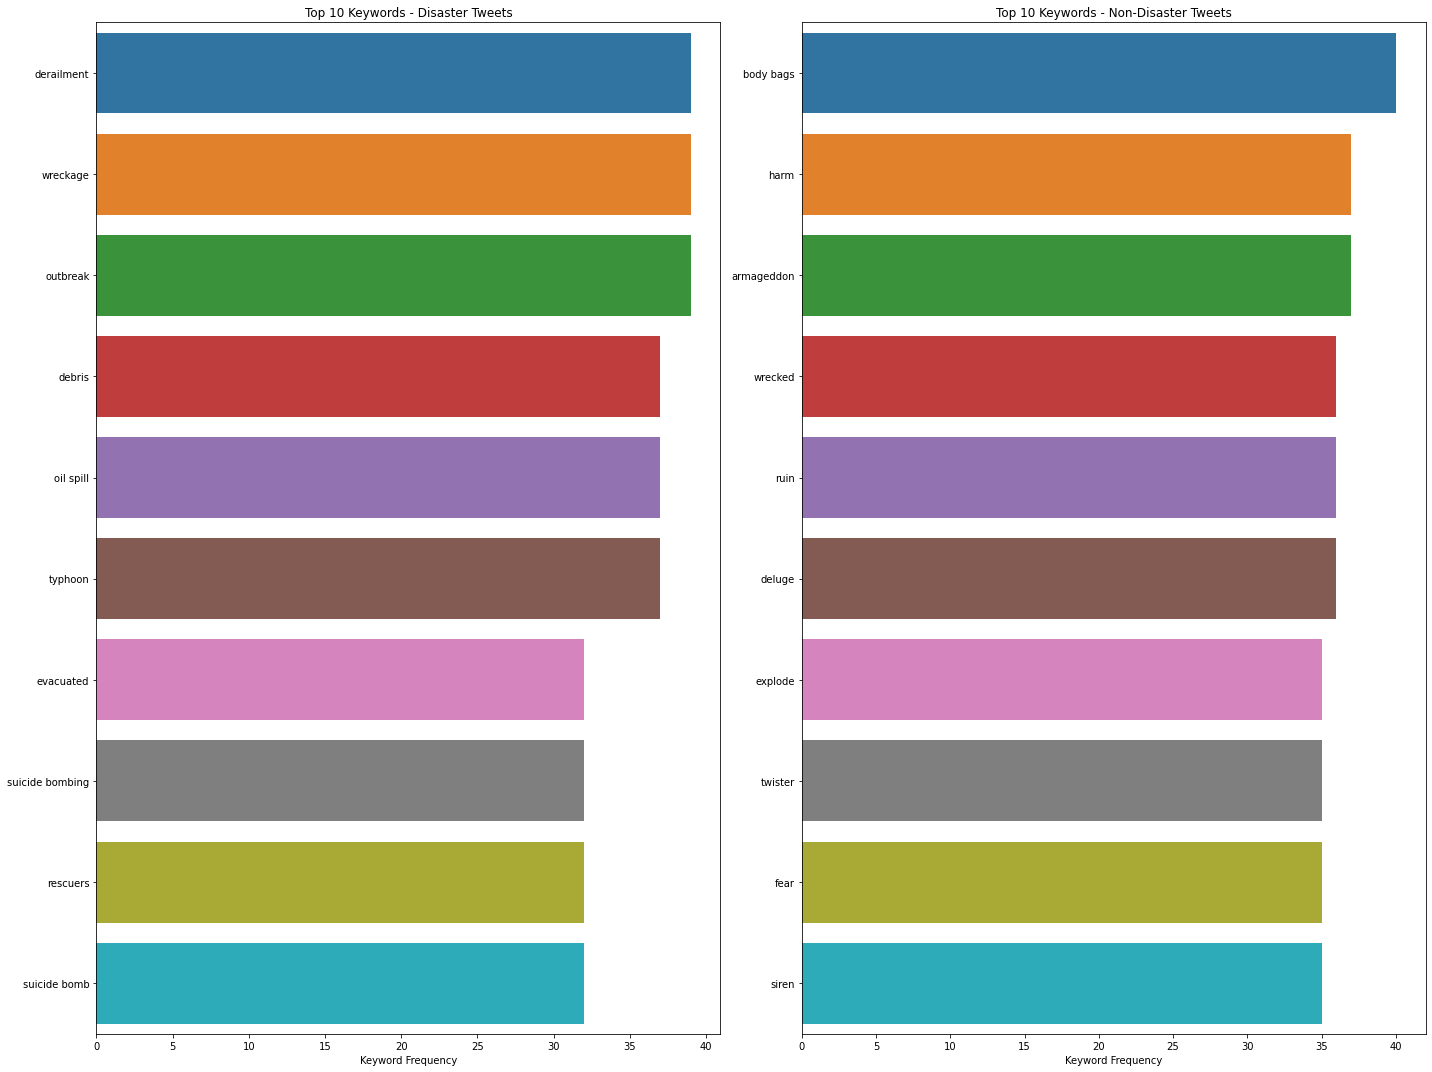

In [14]:
fig, ax = plt.subplots(1,2, figsize=(20,15))

sns.barplot(y = disaster_keywords[0:10].index, x = disaster_keywords[0:10],orient='h', 
            ax=ax[0], palette="tab10")

sns.barplot(y=nondisaster_keywords[0:10].index, x=nondisaster_keywords[:10], orient='h', 
            ax=ax[1], palette="tab10")

ax[0].set_title("Top 10 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 10 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()


## Cleaning before preprocessing 

In [15]:
# Using text and target columns in our model

In [16]:
df_train = train[["text","target"]]

In [17]:
df_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
# Cleaning function
def clean_text(text): 
  text = text.lower()  # lowercase
  text = re.sub(r'@[A-Za-z0-9_]+' , '' , text)   #remove mentions
  text = re.sub(r'#' , '' , text) #remove hashtags
  text = re.sub(r'RT : ','' , text) # remove retweets
  text = re.sub(r'https?:\/\/[A-Za-z0-9\./\/]+' , '' , text) #removes url
  text = re.sub('\[.*?\]' , '' , text) #remove square brackets
  text = re.sub(r'[^\w\s]' , '' , text) #remove puntuations
  text = re.sub('\w*\d\w*' , '' ,text) #removes words containig numbers
  text = re.sub('\n' , '' ,text) #remove new lines

  text = re.sub(r'@[A-Za-z0-9]+','', text)
  text = re.sub(r'#','', text)
  text = re.sub(r'rt[\s]+','', text)
  text = re.sub(r'https?:\/\/S+','', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>_+=-]", "", text) 
  text = re.sub('\S*@\S*\s?', '', text)  # remove emails
  text = re.sub('\s+', ' ', text)  # remove newline chars
  text = re.sub("\'", "", text)  # remove single quotes
  text = re.sub("(\s\d+)","",text)  # remove number
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text)   
  text = re.sub(r"i'm", "i am", text)
  text = re.sub(r"he's", "he is", text)
  text = re.sub(r"she's", "she is", text)
  text = re.sub(r"that's", "that is", text)        
  text = re.sub(r"what's", "what is", text)
  text = re.sub(r"where's", "where is", text) 
  text = re.sub(r"\'ll", " will", text)  
  text = re.sub(r"\'ve", " have", text)  
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"won't", "will not", text)
  text = re.sub(r"don't", "do not", text)
  text = re.sub(r"did't", "did not", text)
  text = re.sub(r"can't", "can not", text)
  text = re.sub(r"it's", "it is", text)
  text = re.sub(r"couldn't", "could not", text)
  text = re.sub(r"have't", "have not", text)
  text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text) 
  
 
  return text

In [19]:
df_train["text_cleaned"] = df_train["text"].apply(clean_text)

In [20]:
# For removing digits
def remove_digits(text):
  text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
  table = str.maketrans('', '', string.punctuation)
  text = ''.join([i for i in text if not i.isdigit()])
  return text

In [21]:
df_train["text_cleaned"] = df_train["text_cleaned"].apply(remove_digits)

In [22]:
df_train.head()

,text,target,text_cleaned
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [23]:
disaster_tweets = df_train.loc[df_train["target"] == 1]["text_cleaned"]
disaster_tweets.head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text_cleaned, dtype: object

In [24]:
nondisaster_tweets = df_train.loc[df_train["target"] == 0]["text_cleaned"]
nondisaster_tweets.head()

15              whats up man
16             i love fruits
17          summer is lovely
18         my car is so fast
19    what a goooooooaaaaaal
Name: text_cleaned, dtype: object

In [25]:
#. Removing all non alphanumeric characters except whitespaces
df_train["text_cleaned"] = df_train["text_cleaned"].apply( lambda x:''.join(ch for ch in x if ch.isalnum() or ch == " "))
# Removing double spaces and spaces at the beginning and end of strings
df_train["text_cleaned"]  = df_train["text_cleaned"].apply(lambda x: x.replace(" +","").lower().strip())
# remove stop words and replace everyword with their lemma
df_train["text_cleaned"] = df_train["text_cleaned"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [26]:
df_train.head()

,text,target,text_cleaned
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...


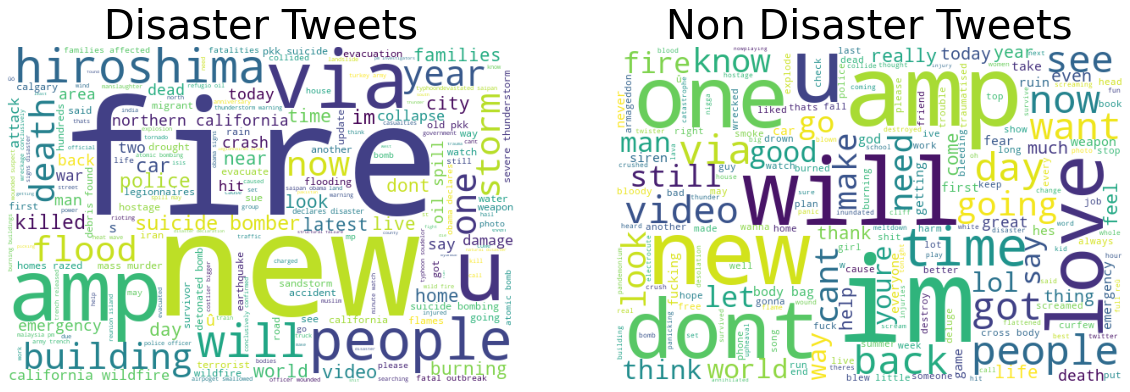

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 10])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(nondisaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);


In [28]:
# Instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None) # Instanciate the tokenizer


In [29]:
tokenizer.fit_on_texts(df_train["text_cleaned"])
df_train["text_encoded"] = tokenizer.texts_to_sequences(df_train["text_cleaned"])
df_train["len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_final= df_train[df_train["len_text"]!=0]

In [30]:
df_final.head()

,text,target,text_cleaned,text_encoded,len_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive,"[392, 156]",2
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[111, 2, 147, 498, 967]",5
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...,"[423, 303, 277, 170, 303, 263, 364]",7
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,"[7, 65, 170, 263, 34]",5
4,Just got sent this photo from Ruby #Alaska as ...,1,got send photo ruby alaska smoke wildfire pour...,"[242, 164, 118, 157, 65, 101]",6


In [31]:
#Define the maxlen
maxlen=df_final["text_cleaned"].apply(lambda x: len(x.split())).max()
maxlen

21

In [ ]:
tokenizer.index_word

To form a tensorflow dataset, all the sequences must be of the same length, so we'll use padding. Padding will result in adding zeros at the end or the beginning of each sentence in order for all sequences to be of the same length.

In [33]:
train_pad_text = tf.keras.preprocessing.sequence.pad_sequences(df_final.text_encoded, padding="post",maxlen=maxlen)
train_pad_text

array([[392, 156,   0, ...,   0,   0,   0],
       [111,   2, 147, ...,   0,   0,   0],
       [423, 303, 277, ...,   0,   0,   0],
       ...,
       [  5, 374,   0, ...,   0,   0,   0],
       [ 22, 697,  81, ...,   0,   0,   0],
       [103,  23, 341, ...,   0,   0,   0]], dtype=int32)

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
y = df_final["target"]

In [36]:
# Split the dataset
X_train, X_valtest, y_train, y_valtest = train_test_split(train_pad_text,
                                                          y,
                                                          test_size=0.4,
                                                          stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest,
                                                test_size=0.5,
                                                stratify=y_valtest)


## **2.- MODELING**

Embedding

In [37]:
vocab_size = len(tokenizer.index_word)

model_emb = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(input_dim=vocab_size+1,output_dim=128, input_shape=[X_train.shape[1],], name="embedding"),
                  Conv1D(filters=15,
                         kernel_size=(2),
                         activation="relu"),
              
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dropout(0.2),


                  # Couche Dense classique
                  tf.keras.layers.Dense(32, activation='relu'), 
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dropout(0.4),
              

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid",kernel_regularizer=tf.keras.regularizers.l1(0.01))])

model_emb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 128)           1629568   
                                                                 
 conv1d (Conv1D)             (None, 20, 15)            3855      
                                                                 
 global_average_pooling1d (G  (None, 15)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 32)                512       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [38]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_emb.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [39]:
weights = dict(1/(train.target).value_counts()/sum(1/(train.target).value_counts())*5)
weights

{0: 2.1482989623013267, 1: 2.8517010376986733}

In [40]:
history = model_emb.fit(x=X_train,y=y_train,batch_size = 32, 
                    epochs=10, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50,verbose=2)

Epoch 1/10
50/50 - 8s - loss: 0.7364 - binary_accuracy: 0.5681 - val_loss: 0.7280 - val_binary_accuracy: 0.5693 - 8s/epoch - 153ms/step
Epoch 2/10
50/50 - 0s - loss: 0.7241 - binary_accuracy: 0.5694 - val_loss: 0.7129 - val_binary_accuracy: 0.5693 - 305ms/epoch - 6ms/step
Epoch 3/10
50/50 - 0s - loss: 0.7008 - binary_accuracy: 0.6068 - val_loss: 0.6601 - val_binary_accuracy: 0.7011 - 394ms/epoch - 8ms/step
Epoch 4/10
50/50 - 0s - loss: 0.6355 - binary_accuracy: 0.7000 - val_loss: 0.5773 - val_binary_accuracy: 0.7753 - 359ms/epoch - 7ms/step
Epoch 5/10
50/50 - 0s - loss: 0.5479 - binary_accuracy: 0.7794 - val_loss: 0.5159 - val_binary_accuracy: 0.7840 - 317ms/epoch - 6ms/step
Epoch 6/10
50/50 - 0s - loss: 0.5201 - binary_accuracy: 0.7908 - val_loss: 0.4997 - val_binary_accuracy: 0.7906 - 370ms/epoch - 7ms/step
Epoch 7/10
50/50 - 0s - loss: 0.5112 - binary_accuracy: 0.7969 - val_loss: 0.4946 - val_binary_accuracy: 0.7979 - 315ms/epoch - 6ms/step
Epoch 8/10
50/50 - 0s - loss: 0.4524 - bin

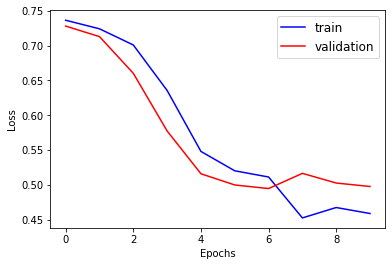

In [41]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b",label="train")
plt.plot(history.history["val_loss"], color="r",label="validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(fontsize= 12)
plt.show()

In [42]:
#Prediction on training set
y_train_pred = model_emb.predict(X_train)
#Prediction on test set
y_test_pred = model_emb.predict(X_test)

48/48 [==============================] - 0s 1ms/step


In [43]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8570481661511268
accuracy score test : 0.7846255798542081
f1 score train : 0.8231757310740639
f1 score test : 0.7359870024370431


In [51]:
df_test = pd.read_csv("/content/test.csv")
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [52]:
df_test["text_clean"] = df_test["text"].apply(clean_text)

In [53]:
df_test["text_clean"] = df_test["text"].apply(remove_digits)

In [55]:
df_test["text_cleaned"] = df_test["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_test["text_cleaned"] = df_test["text_cleaned"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_test["text_cleaned"] = df_test["text_cleaned"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
df_test.head()

,id,keyword,location,text,text_clean,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills in China and Taiwan,typhoon soudelor kill china taiwan


In [56]:
tokenizer.fit_on_texts(df_test["text_cleaned"])
df_test["text_encoded"] = tokenizer.texts_to_sequences(df_test["text_cleaned"])

In [57]:
test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_test["text_encoded"],padding="post",maxlen=maxlen)
test_pad.shape

(3263, 21)

In [58]:
prediction = model_emb.predict(test_pad)

102/102 [==============================] - 0s 2ms/step


In [59]:
prediction

array([[0.657393  ],
       [0.05432343],
       [0.68705213],
       ...,
       [0.16218868],
       [0.48433793],
       [0.42350838]], dtype=float32)

In [60]:
prediction.shape

(3263, 1)

In [148]:
sample_sub = pd.read_csv("/content/sample_submission.csv")

In [149]:
sample_sub['target'] = prediction

In [150]:
sample_sub["target"] = sample["target"].apply(lambda x : 0 if x <=0.5 else 1)

In [151]:
sample_sub.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,0


### **GRU**

In [65]:
vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1,128, input_shape=[X_train.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dense(1, activation="sigmoid")
])

In [66]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model_gru.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [67]:
weights = dict(1/(train.target).value_counts()/sum(1/(train.target).value_counts())*5)
weights

{0: 2.1482989623013267, 1: 2.8517010376986733}

In [69]:
history_gru = model_gru.fit(x=X_train,y=y_train,batch_size =32, 
                    epochs=30, 
                    validation_data=(X_val,y_val),class_weight=weights,verbose=2)

Epoch 1/30
142/142 - 1s - loss: 1.6994 - binary_accuracy: 0.4313 - val_loss: 0.6937 - val_binary_accuracy: 0.4307 - 1s/epoch - 9ms/step
Epoch 2/30
142/142 - 1s - loss: 1.6994 - binary_accuracy: 0.4313 - val_loss: 0.6937 - val_binary_accuracy: 0.4307 - 1s/epoch - 7ms/step
Epoch 3/30
142/142 - 1s - loss: 1.6991 - binary_accuracy: 0.4728 - val_loss: 0.6916 - val_binary_accuracy: 0.7223 - 1s/epoch - 7ms/step
Epoch 4/30
142/142 - 1s - loss: 1.4205 - binary_accuracy: 0.7112 - val_loss: 0.4782 - val_binary_accuracy: 0.7919 - 1s/epoch - 7ms/step
Epoch 5/30
142/142 - 1s - loss: 1.0750 - binary_accuracy: 0.8126 - val_loss: 0.4841 - val_binary_accuracy: 0.7780 - 1s/epoch - 8ms/step
Epoch 6/30
142/142 - 1s - loss: 0.9993 - binary_accuracy: 0.8325 - val_loss: 0.4818 - val_binary_accuracy: 0.7826 - 1s/epoch - 8ms/step
Epoch 7/30
142/142 - 1s - loss: 0.9584 - binary_accuracy: 0.8405 - val_loss: 0.4805 - val_binary_accuracy: 0.7840 - 1s/epoch - 7ms/step
Epoch 8/30
142/142 - 1s - loss: 0.9278 - binary_

In [70]:
#Prediction on training set
y_train_pred = model_gru.predict(X_train)
#Prediction on test set
y_test_pred = model_gru.predict(X_test)

48/48 [==============================] - 0s 3ms/step


In [71]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.9239946973044632
accuracy score test : 0.7753479125248509
f1 score train : 0.910135841170324
f1 score test : 0.7307386814932485


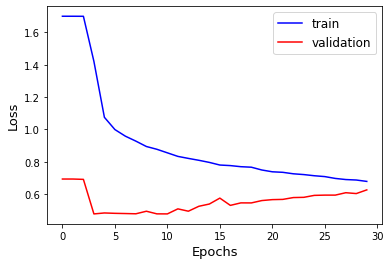

In [72]:
# Visualization of the training process on the loss function 
plt.plot(history_gru.history["loss"], color="b", label='train')
plt.plot(history_gru.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

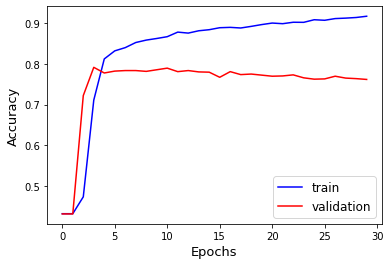

In [73]:
# Visualization of accuracy training 
plt.plot(history_gru.history["binary_accuracy"], color="b", label='train')
plt.plot(history_gru.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

In [74]:
pred_gru = model_gru.predict(test_pad)

102/102 [==============================] - 0s 3ms/step


In [75]:
pred_gru

array([[0.93500376],
       [0.07847384],
       [0.95679617],
       ...,
       [0.07721685],
       [0.88081306],
       [0.10298786]], dtype=float32)

In [76]:
sample['target'] = pred_gru

In [77]:
sample["target"] = sample["target"].apply(lambda x : 0 if x <=0.5 else 1)

In [78]:
sample.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,0


## LSTM

In [135]:
vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
   # This layers encodes the string as sequences of int
  Embedding(input_dim=vocab_size+1, output_dim=128, input_shape=[X_train.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of
  # the zero padding)
  tf.keras.layers.LSTM(units=64, return_sequences=True), # maintains the sequential nature
  tf.keras.layers.Dropout(0.4),
  # Bidirectional
  tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)), # returns the last output
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
  tf.keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
  tf.keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'),
  tf.keras.layers.Dense(8, kernel_regularizer=keras.regularizers.l2(0.01), activation='relu'), # a dense layer
  tf.keras.layers.Dense(1,  kernel_regularizer=keras.regularizers.l2(0.01),activation="sigmoid") # the prediction layer
])
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 128)           2435840   
                                                                 
 lstm_13 (LSTM)              (None, 21, 64)            49408     
                                                                 
 dropout_17 (Dropout)        (None, 21, 64)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 21, 128)          66048     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 21, 128)           0         
                                                                 
 flatten_6 (Flatten)         (None, 2688)              0         
                                                      

In [136]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [137]:
weights = dict(1/(train.target).value_counts()/sum(1/(train.target).value_counts())*5)
weights

{0: 2.1482989623013267, 1: 2.8517010376986733}

In [138]:
history_lstm = model_lstm.fit(x=X_train,y=y_train,batch_size=32, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch=30,class_weight=weights,verbose=2)

Epoch 1/15
30/30 - 6s - loss: 3.9192 - binary_accuracy: 0.5000 - val_loss: 1.8447 - val_binary_accuracy: 0.4307 - 6s/epoch - 201ms/step
Epoch 2/15
30/30 - 0s - loss: 2.5134 - binary_accuracy: 0.5271 - val_loss: 1.2452 - val_binary_accuracy: 0.7031 - 496ms/epoch - 17ms/step
Epoch 3/15
30/30 - 0s - loss: 1.9140 - binary_accuracy: 0.7427 - val_loss: 0.9850 - val_binary_accuracy: 0.7753 - 479ms/epoch - 16ms/step
Epoch 4/15
30/30 - 1s - loss: 1.7092 - binary_accuracy: 0.7521 - val_loss: 0.8490 - val_binary_accuracy: 0.7714 - 509ms/epoch - 17ms/step
Epoch 5/15
30/30 - 0s - loss: 1.4520 - binary_accuracy: 0.7951 - val_loss: 0.7724 - val_binary_accuracy: 0.7820 - 488ms/epoch - 16ms/step
Epoch 6/15
30/30 - 1s - loss: 1.4190 - binary_accuracy: 0.8031 - val_loss: 0.6955 - val_binary_accuracy: 0.7966 - 510ms/epoch - 17ms/step
Epoch 7/15
30/30 - 0s - loss: 1.2227 - binary_accuracy: 0.8229 - val_loss: 0.6698 - val_binary_accuracy: 0.7906 - 497ms/epoch - 17ms/step
Epoch 8/15
30/30 - 1s - loss: 1.2549

In [139]:
#Prediction on training set
y_train_pred = model_lstm.predict(X_train)
#Prediction on test set
y_test_pred = model_lstm.predict(X_test)

48/48 [==============================] - 0s 4ms/step


In [140]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8643393725143614
accuracy score test : 0.7879390324718356
f1 score train : 0.8379947229551452
f1 score test : 0.7452229299363057


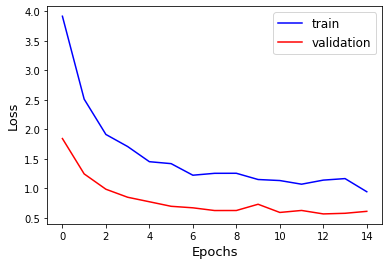

In [141]:
# Visualization of the training process on the loss function 
plt.plot(history_lstm.history["loss"], color="b", label='train')
plt.plot(history_lstm.history["val_loss"], color="r", label='validation')
plt.ylabel("Loss", fontsize = 13)
plt.xlabel("Epochs", fontsize = 13)
plt.legend(fontsize= 12)
plt.show()

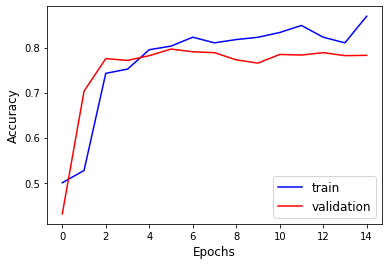

In [142]:
# Visualization of accuracy training 
plt.plot(history_lstm.history["binary_accuracy"], color="b", label='train')
plt.plot(history_lstm.history["val_binary_accuracy"], color="r", label='validation')
plt.ylabel("Accuracy", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.legend(fontsize= 12)
plt.show()

In [143]:
pred_lstm = model_lstm.predict(test_pad)

102/102 [==============================] - 0s 4ms/step


In [144]:
submission = pd.read_csv("/content/sample_submission.csv")

In [145]:
submission['target'] = pred_lstm

In [146]:
submission["target"] = sample["target"].apply(lambda x : 0 if x <=0.5 else 1)

In [111]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,0


References : 
https://app.jedha.co/course/natural-language-processing-pt/understand-embedding-pt

https://app.jedha.co/course/recurrent-neural-network-courses-pt/code-recurrent-neural-networks-pt
